# Так верна ли гипотеза?

Основной ноутбук с анализом. Остальные лишь готовили датасет. 

Группируем данные, считаем погрешность, строим графики. 
В качестве бонуса генерируем облака слов

In [2]:
 # coding: utf-8
# наше всё
import numpy as np
import pandas as pd

#настройки pandas, с которыми лучше почти всегда
pd.set_option('display.max_rows', 45000)
pd.set_option('display.max_columns', 50000)
pd.set_option('display.max_colwidth', 5000)

import requests
import time

In [3]:
# загрузка датасетов
# эти файлы получены в ноутбуке users_working.ipynb
# user_id и сообщество, в котором он состоит
groups_users=pd.read_csv('users.csv')
# user_id и инфа по нему
users_info=pd.read_csv('big_data.csv', header=None, sep=';')
users_info.columns=['first_name', 'id', 'last_name', 'music', 'sex']

In [4]:
# посмотрим на всякий случай
groups_users.sample(3)

,user_id,group,group_id
11927,257275,ВИКТОР ЦОЙ РОК ГРУППА КИНО,1090630
16263,133003168,Стас Михайлов,144798458
5506,908422,Nautilus Pompilius,2902


In [5]:
users_info.sample(3)

,first_name,id,last_name,music,sex
25431,DELETED,324696,NaN,No info,0
31002,Дмитрий,3051188,Шушпанов,No info,2
8311,Аня,102096631,Зубарева,No info,1


In [6]:
# собираем всю инфу вместе
df=users_info.merge(groups_users, 'left', left_on='id', right_on='user_id')

In [7]:
# словарь, в котором мы проставляем пол основного вокалиста
gend_dict={
    'Земфира': 1,
    'Стас Михайлов':2,
    'Мумий Тролль (Mumiy Troll)':2,
    'Группа Мельница':1,
    'КИПЕЛОВ | АРИЯ':2,
    'Диана Арбенина. Ночные Снайперы':1,
    'Группа Корни':2,
    'ЧАЙФ':2,
    'ДДТ клуб':2,
    'ВИКТОР ЦОЙ РОК ГРУППА КИНО':2,
    'Группа «Пикник»':2,
    'Би-2':2,
    'Nautilus Pompilius':2,
    'Архивы Король и Шут':2,
    'Группа ПилОт':2,
    'Группа АЛИСА':2,
    'Сурганова и Оркестр. Светлана Сурганова':1,
    'СПЛИН':2,
    'Король и Шут':2,
    'Любители групп «Ария» и «Кипелов»':2,
    'Армия АлисА': 2,
    'FLЁUR / ФЛЁР': 1
          }
df['group_gender']=df['group'].map(gend_dict)

# кажется, теперь всё готово

In [8]:
# для начала посмотрим выборку в целом
totals=df.groupby('sex').agg(
                {
                    'id': lambda x: x.nunique(),
                }).reset_index()
totals['share']=totals['id']/np.sum(totals['id'])
# базовая доля девушек, отправная точка сравнения
base_fem_share=totals[totals['sex']==1]['share'].values[0]

In [9]:
totals

,sex,id,share
0,0,62,0.002919
1,1,11590,0.545694
2,2,9587,0.451387


In [10]:
# 55%, девушек чуть-чуть больше, ну что же, кто говорил, что будет легко

In [11]:
# выводим параметры выборки, которые нам нужны
# на входе датасет и уровень доверия 
def all_params(data, confidence):
    import scipy.stats
    import math
    # рамзер выборки
    nn = len(data)
    # среднее
    m = np.mean(data)
    # стандартное отклонение
    std_err = np.std(data)
    # доверительный интервал при неизвестной дисперсии
    h = std_err * scipy.stats.t.interval(confidence, nn-1, loc=0, scale=1)[1]/math.sqrt(nn)
    # выводим параметры в каком-то порядке
    return nn, m, std_err, h, m-h, m+h

In [12]:
# составляем датафрйем с параметрами
params_df=pd.DataFrame()
# цикл по группам
for group in df['group'].value_counts().index:
    # вытаскиваем параметр с уровнем доверия 90%
    # пол тупо складываем, 1.5 - полное равноправие (м+ж/2: (1+2)/2 )
    params_lst=all_params(df[df['group']==group]['sex'], 0.9)
    p_df=pd.DataFrame([params_lst], columns=[
                                    'sample_size',
                                    'mean',
                                    'standart error',
                                    'interval', 
                                    'low',
                                    'high'
                                               ])
    p_df['group']=group
    # переходим к тому, что идеальный баланс - это 0, 
    # девочки в минусы, мальчики в плюсе
    p_df['mean']=p_df['mean']-1.5
    p_df['low']=p_df['low']-1.5
    p_df['high']=p_df['high']-1.5
    params_df=pd.concat([params_df, p_df])
params_df['group_gender']=params_df['group'].map(gend_dict)
# сортировка по полу исполнителя
params_df=params_df.sort_values(by='group_gender')
params_df=params_df.set_index('group')

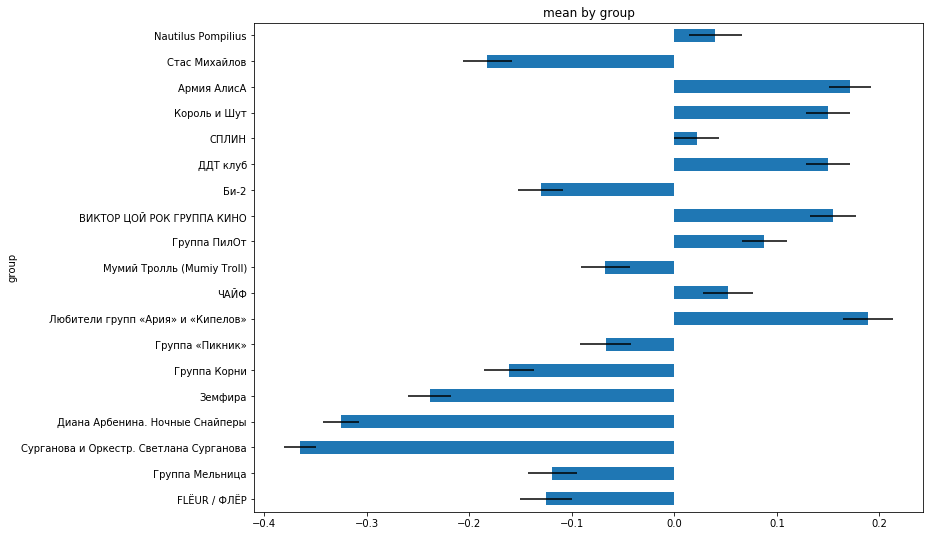

In [21]:
# рисуем графики и интервалы погрещности не забываем
from matplotlib import pyplot as plt
ax = params_df['mean'].plot(
                             label='Mean',
                             title='mean by group',
                             figsize=(12,9),
                             kind='barh',
                             xerr = params_df['interval'] 
                           )


In [14]:
# 5 из 5 для женских групп - похоже, первые выводы можно делать

In [15]:
# или таблицей, кому как комфортно
params_df

,sample_size,mean,standart error,interval,low,high,group_gender
group,,,,,,,
FLЁUR / ФЛЁР,1000,-0.125000,0.484123,0.025205,-0.150205,-0.099795,1
Группа Мельница,1134,-0.119048,0.485621,0.023740,-0.142787,-0.095308,1
Сурганова и Оркестр. Светлана Сурганова,1296,-0.364969,0.341757,0.015626,-0.380595,-0.349343,1
Диана Арбенина. Ночные Снайперы,1294,-0.325348,0.379669,0.017373,-0.342721,-0.307975,1
Земфира,1145,-0.238865,0.439254,0.021369,-0.260234,-0.217495,1
Группа Корни,1001,-0.161339,0.473255,0.024627,-0.185965,-0.136712,2
Группа «Пикник»,1097,-0.067001,0.495491,0.024628,-0.091629,-0.042373,2
Любители групп «Ария» и «Кипелов»,1100,0.189091,0.487730,0.024209,0.164882,0.213300,2
ЧАЙФ,1142,0.052539,0.497232,0.024222,0.028318,0.076761,2


А теперь бонус - смотрим, что можно вытащить из анкеты

In [16]:
# токенизатор, на входе текст, на выходе - массив слов
def parse_field(txt):
    txt=txt.lower()
    from nltk.tokenize import RegexpTokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    tokens=tokenizer.tokenize(txt)   
    
    return tokens

In [17]:
# основной цикл
# считаем для каждой группы частность слов
words_df=pd.DataFrame()
for group in df['group'].value_counts().index:
    gr_lst=[]
    for f in df[df['group']==group]['music'].values:
        tmp_lst=parse_field(f)
        gr_lst=gr_lst+tmp_lst
    all_voc=pd.DataFrame(gr_lst, columns=['words'])
    ank_df=pd.DataFrame(all_voc['words'].value_counts())
    ank_df['group']=group
    words_df=pd.concat([words_df, ank_df])
words_df=words_df.reset_index()

In [18]:
words_df.sample(3)

,index,words,group
20584,niyaz,1,FLЁUR / ФЛЁР
16361,day,6,Группа «Пикник»
18915,sting,1,Стас Михайлов


In [19]:
# подготовка структуры данных для облака слов
# отправляет слова, которые встретили не менее n раз
def prep_gr_word_cloud(words_df, group, n):
    common=words_df[
        (words_df['words']>n)&
        (words_df['group']==group)&
        # загулшку остутсвия данных не выводим
        (words_df['index']!='no')&(words_df['index']!='info')
            ][['index', 'words']].set_index('index').to_dict()['words']
    
    return common
# функция строит облако слов и сохраняет её в файл
# для работы нужно pip install wordcloud
# https://github.com/amueller/word_cloud
def write_cloud(dct, file):
    from wordcloud import WordCloud
    wc = WordCloud(width=2600, height=2200, background_color="black", relative_scaling=1.0,
               collocations=False, min_font_size=10).generate_from_frequencies(dict(dct))
    plt.axis("off")
    plt.figure(figsize=(9, 6))
    plt.imshow(wc, interpolation="bilinear")
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.savefig(file, format="png")
#     plt.show()

In [20]:
# запускаем машинку, если слово есть у трёх и более человек из тысячи - рисуем его
for group in df['group'].value_counts().index:
    print(group)
    dct=prep_gr_word_cloud(words_df, group, 3)
    write_cloud(dct, group+'.png')